<a href="https://colab.research.google.com/github/parsa-abbasi/Sentiment-Analysis/blob/master/Multiclass-Classification/DL_KerasEmb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requirements

## Install required libraries

In [117]:
!pip install matplotlib==3.1.0

In [118]:
!pip install hazm
!pip install stopwords_guilannlp

## Import Libraries

In [0]:
# General
import numpy as np
import pandas as pd
import codecs
from google.colab import files
# Keras
from keras import optimizers
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Embedding, Dropout
from keras.layers import GlobalMaxPool1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import CuDNNLSTM, LSTM, Bidirectional
from keras.layers.convolutional import Conv1D
from keras.utils.np_utils import to_categorical
from keras.metrics import categorical_accuracy
from keras.utils import plot_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# Preprocessing
from stopwords_guilannlp import stopwords_output
from hazm import *
# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
from keras.utils import plot_model
# Measuring metrics
from sklearn.metrics import f1_score

# Upload dataset files

Upload dataset files to colab environment

In [121]:
uploaded = files.upload()

Saving balanced.csv to balanced.csv
Saving original.csv to original.csv
Saving test.csv to test.csv
Saving translation.csv to translation (1).csv



# Import & Analyze Dataset

In [0]:
test = pd.read_csv('test.csv', index_col=None, header=None, encoding="utf-8")

In [0]:
x_test = test[0]
y_test = test[1]

In [124]:
print('Number of testing sentence: ', x_test.shape)
print('Number of testing label: ', y_test.shape)

Number of testing sentence:  (1854,)
Number of testing label:  (1854,)


In [0]:
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

In [0]:
original = pd.read_csv('original.csv', index_col=None, header=None, encoding="utf-8")
balanced = pd.read_csv('balanced.csv', index_col=None, header=None, encoding="utf-8")
translation = pd.read_csv('translation.csv', index_col=None, header=None, encoding="utf-8")

In [0]:
selected_dataset = translation

In [0]:
selected_dataset = selected_dataset.sample(frac=1).reset_index(drop=True)

In [0]:
x_train = selected_dataset[0]
y_train = selected_dataset[1]

In [181]:
print('Number of training sentence: ', x_train.shape)
print('Number of training label: ', y_train.shape)

Number of training sentence:  (14046,)
Number of training label:  (14046,)


In [0]:
# Convert dataframes to numpy arrays
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

In [183]:
# See the data number of sentence in each category 
from collections import Counter
cnt = Counter(y_train)
cnt = dict(cnt)
print(cnt)

{0: 4000, 2: 3856, 1: 4000, -1: 1874, -2: 316}


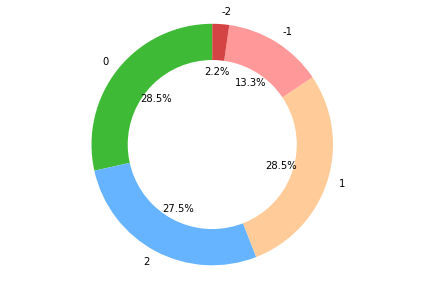

In [184]:
labels = list(cnt.keys())
sizes = list(cnt.values())
colors = ['#3fba36', '#66b3ff','#ffcc99','#ff9999', '#d44444']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
# Decomment following line if you want to save the figure
# plt.savefig('distribution.png')
plt.show()

In [0]:
# Decomment following line if you want to download dataset figure
# files.download('distribution.png')

# Preprocess

In [0]:
puncs = ['،', '.', ',', ':', ';', '"']
normalizer = Normalizer()
lemmatizer = Lemmatizer()

# turn a doc into clean tokens
def clean_doc(doc):
    doc = normalizer.normalize(doc) # Normalize document using Hazm Normalizer
    tokenized = word_tokenize(doc)  # Tokenize text
    tokens = []
    for t in tokenized:
      temp = t
      for p in puncs:
        temp = temp.replace(p, '')
      tokens.append(temp)
    # tokens = [w for w in tokens if not w in stop_set]    # Remove stop words
    tokens = [w for w in tokens if not len(w) <= 1]
    tokens = [w for w in tokens if not w.isdigit()]
    tokens = [lemmatizer.lemmatize(w) for w in tokens] # Lemmatize sentence words using Hazm Lemmatizer
    tokens = ' '.join(tokens)
    return tokens

# Prepare data for Deep Learning model

## Apply preprocessing to data

In [0]:
# Apply preprocessing step to training data
train_docs = np.empty_like(x_train)
for index, document in enumerate(x_train):
  train_docs[index] = clean_doc(document)

In [0]:
# Applying preprocessing step to test data
test_docs = np.empty_like(x_test)
for index, document in enumerate(x_test):
  test_docs[index] = clean_doc(document)

## Setting tokenizer up

In [0]:
num_words = 2000

# Create the tokenizer
tokenizer = Tokenizer(num_words=num_words)

# fFt the tokenizer on the training documents
tokenizer.fit_on_texts(train_docs)

In [0]:
# Find maximum length of training sentences
max_length = max([len(s.split()) for s in train_docs])

## Embed sentences

In [0]:
# Embed training sequences
encoded_docs = tokenizer.texts_to_sequences(train_docs)

# Pad embeded training sequences
x_train_padded = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [0]:
# Define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index)

In [0]:
# Embed testing sequences
encoded_docs = tokenizer.texts_to_sequences(test_docs)
# Pad testing sequences
x_test_padded = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

# Deep Learning Models

In [0]:
# Prepare labels for categorical prediction
categorical_y_train = to_categorical(y_train, 5)
categorical_y_test = to_categorical(y_test, 5)

## B-LSTM Model

In [0]:
model_blstm = Sequential()
model_blstm.add(Embedding(vocab_size, 300, input_length=max_length))
model_blstm.add(Bidirectional(CuDNNLSTM(300, return_sequences=True, name='lstm_layer')))
model_blstm.add(GlobalMaxPool1D())
model_blstm.add(Dropout(0.2))
model_blstm.add(Dense(300, activation="relu"))
model_blstm.add(Dropout(0.1))
model_blstm.add(Dense(5, activation='softmax'))

In [231]:
model_blstm.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[categorical_accuracy])

model_blstm.summary()
batch_size_blstm = 64
epochs_blstm = 5

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 257, 300)          2332200   
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 257, 600)          1444800   
_________________________________________________________________
global_max_pooling1d_18 (Glo (None, 600)               0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 600)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 300)               180300    
_________________________________________________________________
dropout_30 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 5)               

In [232]:
# Train model
hist_blstm = model_blstm.fit(x_train_padded, categorical_y_train, batch_size=batch_size_blstm, epochs=epochs_blstm, shuffle=True)

Epoch 1/5
14046/14046 [==============================] - 19s 1ms/step - loss: 1.1585 - categorical_accuracy: 0.5061
Epoch 2/5
14046/14046 [==============================] - 16s 1ms/step - loss: 0.8682 - categorical_accuracy: 0.6615
Epoch 3/5
14046/14046 [==============================] - 16s 1ms/step - loss: 0.7598 - categorical_accuracy: 0.7065
Epoch 4/5
14046/14046 [==============================] - 16s 1ms/step - loss: 0.6785 - categorical_accuracy: 0.7348
Epoch 5/5
14046/14046 [==============================] - 16s 1ms/step - loss: 0.6016 - categorical_accuracy: 0.7642


In [224]:
# Evaluate model
loss_blstm, acc_blstm = model_blstm.evaluate(x_test_padded, categorical_y_test, verbose=0)
print('Test Accuracy: %f' % (acc_blstm*100))

Test Accuracy: 65.156419


In [0]:
# Get prediction label
y_pred_blstm = model_blstm.predict_classes(x_test_padded)

## CNN Model

In [0]:
model_cnn = Sequential()
model_cnn.add(Embedding(vocab_size, 300, input_length=max_length))
model_cnn.add(Conv1D(filters=64, kernel_size=4, activation='relu', padding='same'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(filters=64, kernel_size=8, activation='relu', padding='same'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(filters=64, kernel_size=16, activation='relu', padding='same'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dropout(0.1))
model_cnn.add(Dense(500, activation="sigmoid"))
model_cnn.add(Dense(5, activation='softmax'))

In [201]:
model_cnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[categorical_accuracy])

model_cnn.summary()
batch_size_cnn = 64
epochs_cnn = 8

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 257, 300)          2332200   
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 257, 64)           76864     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 128, 64)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 128, 64)           32832     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 64, 64)            0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 64, 64)            65600     
_________________________________________________________________
global_max_pooling1d_15 (Glo (None, 64)              

In [202]:
# Train model
hist_cnn = model_cnn.fit(x_train_padded, categorical_y_train, batch_size=batch_size_cnn, epochs=epochs_cnn, shuffle=True)

Epoch 1/8
14046/14046 [==============================] - 5s 329us/step - loss: 1.2341 - categorical_accuracy: 0.4711
Epoch 2/8
14046/14046 [==============================] - 2s 161us/step - loss: 0.9942 - categorical_accuracy: 0.6018
Epoch 3/8
14046/14046 [==============================] - 2s 159us/step - loss: 0.8207 - categorical_accuracy: 0.6835
Epoch 4/8
14046/14046 [==============================] - 2s 159us/step - loss: 0.6791 - categorical_accuracy: 0.7429
Epoch 5/8
14046/14046 [==============================] - 2s 160us/step - loss: 0.5339 - categorical_accuracy: 0.8115
Epoch 6/8
14046/14046 [==============================] - 2s 159us/step - loss: 0.4211 - categorical_accuracy: 0.8544
Epoch 7/8
14046/14046 [==============================] - 2s 164us/step - loss: 0.3475 - categorical_accuracy: 0.8816
Epoch 8/8
14046/14046 [==============================] - 2s 159us/step - loss: 0.2794 - categorical_accuracy: 0.9098


In [203]:
# Evaluate model
loss_cnn, acc_cnn = model_cnn.evaluate(x_test_padded, categorical_y_test, verbose=0)
print('Test Accuracy: %f' % (acc_cnn*100))

Test Accuracy: 65.911543


In [0]:
# Get prediction label
y_pred_cnn = model_cnn.predict_classes(x_test_padded)

# Confusion Matrix

In [0]:
y_test_label = []
for counter in range(0, len(categorical_y_test)):
  label = np.argmax(categorical_y_test[:][counter])
  y_test_label.append(label)
y_test_label = np.array(y_test_label)

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    print(im)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

class_names = np.array([0, 1, 2, -2, -1])
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[456 161  37   4  85]
 [ 54 336 136   2  33]
 [  4  31 316   1   2]
 [  2   0   1   6   3]
 [ 13  39  14   5 113]]
AxesImage(54,36;334.8x217.44)
Normalized confusion matrix
[[0.61 0.22 0.05 0.01 0.11]
 [0.1  0.6  0.24 0.   0.06]
 [0.01 0.09 0.89 0.   0.01]
 [0.17 0.   0.08 0.5  0.25]
 [0.07 0.21 0.08 0.03 0.61]]
AxesImage(54,36;334.8x217.44)


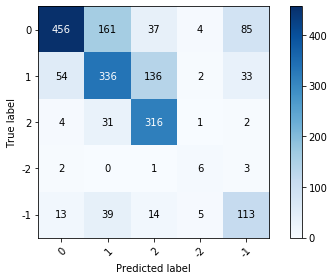

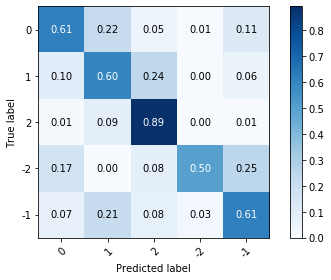

In [208]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_label, y_pred_blstm, classes=class_names)
# plt.savefig('cm-blstm.png')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test_label, y_pred_blstm, classes=class_names, normalize=True)
# plt.savefig('cm-blstm-normalized.png')
plt.show()

Confusion matrix, without normalization
[[428 163  29  24  99]
 [ 41 365  95  19  41]
 [  3  48 301   1   1]
 [  1   1   0   8   2]
 [ 18  26   7  13 120]]
AxesImage(54,36;334.8x217.44)
Normalized confusion matrix
[[0.58 0.22 0.04 0.03 0.13]
 [0.07 0.65 0.17 0.03 0.07]
 [0.01 0.14 0.85 0.   0.  ]
 [0.08 0.08 0.   0.67 0.17]
 [0.1  0.14 0.04 0.07 0.65]]
AxesImage(54,36;334.8x217.44)


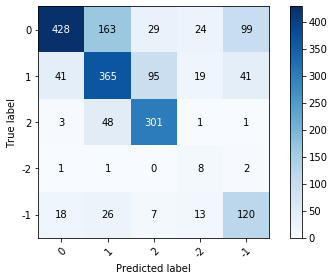

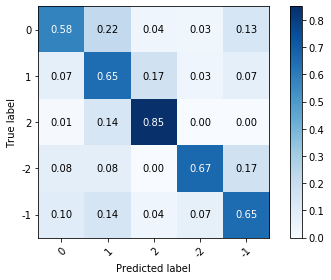

In [209]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_label, y_pred_cnn, classes=class_names)
# plt.savefig('cm-cnn.png')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test_label, y_pred_cnn, classes=class_names, normalize=True)
# plt.savefig('cm-cnn-normalized.png')
plt.show()

## F1 Score

In [210]:
print("F1 score of KerasEmb B-LSTM model:")
f1_score(y_test_label, y_pred_blstm, average='weighted')

F1 score of KerasEmb B-LSTM model:


0.664236524085378

In [211]:
print("F1 score of KerasEmb CNN model:")
f1_score(y_test_label, y_pred_cnn, average='weighted')

F1 score of KerasEmb CNN model:


0.6686346744023779

# Model Visualization

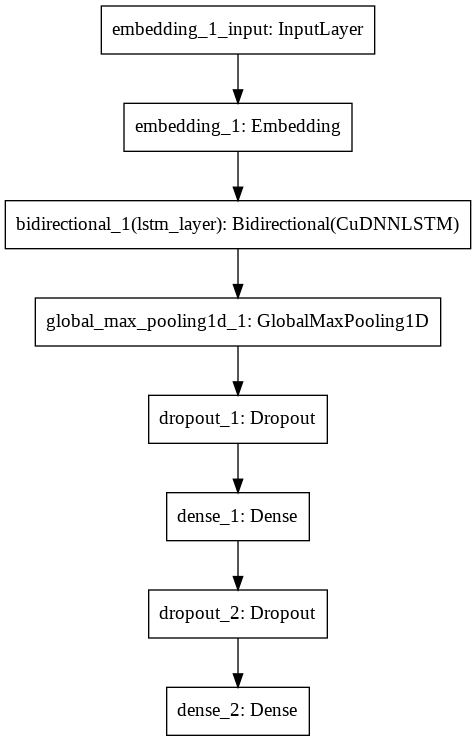

In [38]:
plot_model(model_blstm, to_file='multiclass-blstm.png')

In [0]:
# Decomment following line if you want to download model figure
# files.download('multiclass-blstm.png')

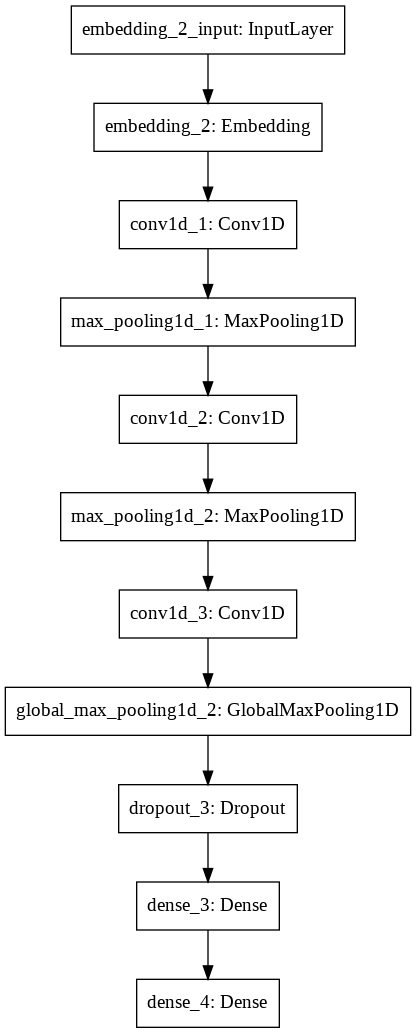

In [40]:
plot_model(model_cnn, to_file='multiclass-cnn.png')

In [0]:
# Decomment following line if you want to download model figure
# files.download('multiclass-cnn.png')